In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the data
corner_data2024 = pd.read_csv("./corner_data/corner_data2024.csv")
corner_data2023 = pd.read_csv("./corner_data/corner_data2023.csv")
corner_data2022 = pd.read_csv("./corner_data/corner_data2022.csv")

corner_data2024.head()
corner_data2023.head()
corner_data2022.head()

corner_data = pd.concat([corner_data2024, corner_data2023, corner_data2022])
corner_data.head()

,Driver,Corner,SpeedClass,Avg_Entry_Speed,Avg_Exit_Speed,Max_Accel_Into,Max_Accel_Out,Max_Decel_Into,Avg_Throttle_Into,Avg_Throttle_Out,Speed_Consistency,Corner_Entry_Count,Corner_Exit_Count,Total_Corner_Samples,EventName,EventDate,Circuit
0,VER,corner_0,Slow,225.000000,109.307699,1.543212,19.290130,-72.222226,0.345451,26.165278,39.297032,1,1,2,Saudi Arabian Grand Prix,2024-03-09,Jeddah
1,VER,corner_7,Medium,241.000000,242.000000,5.208335,5.208332,-8.928619,81.415819,67.594878,1.743912,1,1,2,Saudi Arabian Grand Prix,2024-03-09,Jeddah
2,VER,corner_25,Fast,307.000000,309.000000,2.604167,1.388889,-2.314827,100.000000,100.000000,1.311221,1,1,2,Saudi Arabian Grand Prix,2024-03-09,Jeddah
3,PER,corner_0,Slow,249.000000,125.825000,2.314813,23.148126,-71.180556,0.482729,25.632555,38.732164,1,1,2,Saudi Arabian Grand Prix,2024-03-09,Jeddah
4,PER,corner_7,Medium,242.758334,239.466658,10.416659,6.266711,-8.928572,69.329873,84.136553,0.539057,1,1,2,Saudi Arabian Grand Prix,2024-03-09,Jeddah


In [13]:
corner_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3828 entries, 0 to 1160
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver                3828 non-null   object 
 1   Corner                3828 non-null   object 
 2   SpeedClass            3828 non-null   object 
 3   Avg_Entry_Speed       3828 non-null   float64
 4   Avg_Exit_Speed        3828 non-null   float64
 5   Max_Accel_Into        3828 non-null   float64
 6   Max_Accel_Out         3828 non-null   float64
 7   Max_Decel_Into        3828 non-null   float64
 8   Avg_Throttle_Into     3828 non-null   float64
 9   Avg_Throttle_Out      3828 non-null   float64
 10  Speed_Consistency     3828 non-null   float64
 11  Corner_Entry_Count    3828 non-null   int64  
 12  Corner_Exit_Count     3828 non-null   int64  
 13  Total_Corner_Samples  3828 non-null   int64  
 14  EventName             3828 non-null   object 
 15  EventDate             3828

In [14]:
features_to_scale = [
    'Avg_Entry_Speed',
    'Avg_Exit_Speed', 
    'Max_Accel_Into',
    'Max_Accel_Out',
    'Max_Decel_Into',
    'Avg_Throttle_Into',
    'Avg_Throttle_Out',
    'Speed_Consistency'
]

# Extract only the features we want to scale
features_data = corner_data[features_to_scale]

# Initialize and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_data)

# Convert back to DataFrame for easier handling (optional)
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale)

print(f"Original feature shape: {features_data.shape}")
print(f"Scaled data shape: {scaled_data.shape}")
print(f"Features being scaled: {features_to_scale}")

Original feature shape: (3828, 8)
Scaled data shape: (3828, 8)
Features being scaled: ['Avg_Entry_Speed', 'Avg_Exit_Speed', 'Max_Accel_Into', 'Max_Accel_Out', 'Max_Decel_Into', 'Avg_Throttle_Into', 'Avg_Throttle_Out', 'Speed_Consistency']


Finding optimal number of behavioral clusters...
Clusters: 2, Silhouette Score: 0.415
Clusters: 3, Silhouette Score: 0.418
Clusters: 4, Silhouette Score: 0.344
Clusters: 5, Silhouette Score: 0.360
Clusters: 6, Silhouette Score: 0.336
Clusters: 7, Silhouette Score: 0.338
Clusters: 8, Silhouette Score: 0.327
Clusters: 9, Silhouette Score: 0.322
Clusters: 10, Silhouette Score: 0.320
Clusters: 11, Silhouette Score: 0.240
Clusters: 12, Silhouette Score: 0.265
Optimal number of behavioral clusters: 3
Behavioral clustering completed with 3 clusters
Cluster distribution:
0    2337
1    1144
2     347
Name: count, dtype: int64


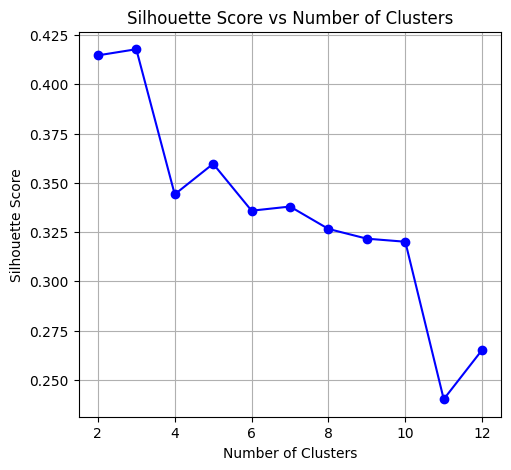

In [15]:
# Stage 1: Cluster individual observations based on telemetry features
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

# Find optimal number of clusters for behavioral clustering
def find_optimal_clusters(data, max_clusters=15, method='agglomerative'):
    """Find optimal number of clusters using silhouette score and elbow method"""
    silhouette_scores = []
    inertias = []
    cluster_range = range(2, max_clusters + 1)
    
    for n_clusters in cluster_range:
        if method == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
            cluster_labels = clusterer.fit_predict(data)
            # No inertia for agglomerative clustering
            inertias.append(None)
        else:  # kmeans
            clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = clusterer.fit_predict(data)
            inertias.append(clusterer.inertia_)
        
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")
    
    return cluster_range, silhouette_scores, inertias

# Find optimal clusters for behavioral clustering
print("Finding optimal number of behavioral clusters...")
cluster_range, sil_scores, inertias = find_optimal_clusters(scaled_data, max_clusters=12, method='agglomerative')

# Plot silhouette scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sil_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

# Find optimal number based on silhouette score
optimal_clusters_behavioral = cluster_range[np.argmax(sil_scores)]
print(f"Optimal number of behavioral clusters: {optimal_clusters_behavioral}")

# Fit the behavioral clustering model
behavioral_clusterer = AgglomerativeClustering(
    n_clusters=optimal_clusters_behavioral, 
    linkage='ward'
)
behavioral_labels = behavioral_clusterer.fit_predict(scaled_data)

# Add cluster labels to original dataframe
corner_data['behavioral_cluster'] = behavioral_labels

print(f"Behavioral clustering completed with {optimal_clusters_behavioral} clusters")
print(f"Cluster distribution:")
print(pd.Series(behavioral_labels).value_counts().sort_index())

Driver-Cluster Profiles Shape: (28, 3)

First 5 drivers' cluster usage:
        Cluster_0  Cluster_1  Cluster_2
Driver                                 
ALB      0.610169   0.299435   0.090395
ALO      0.595960   0.297980   0.106061
BEA      0.444444   0.444444   0.111111
BOT      0.604167   0.296875   0.098958
COL      0.625000   0.291667   0.083333


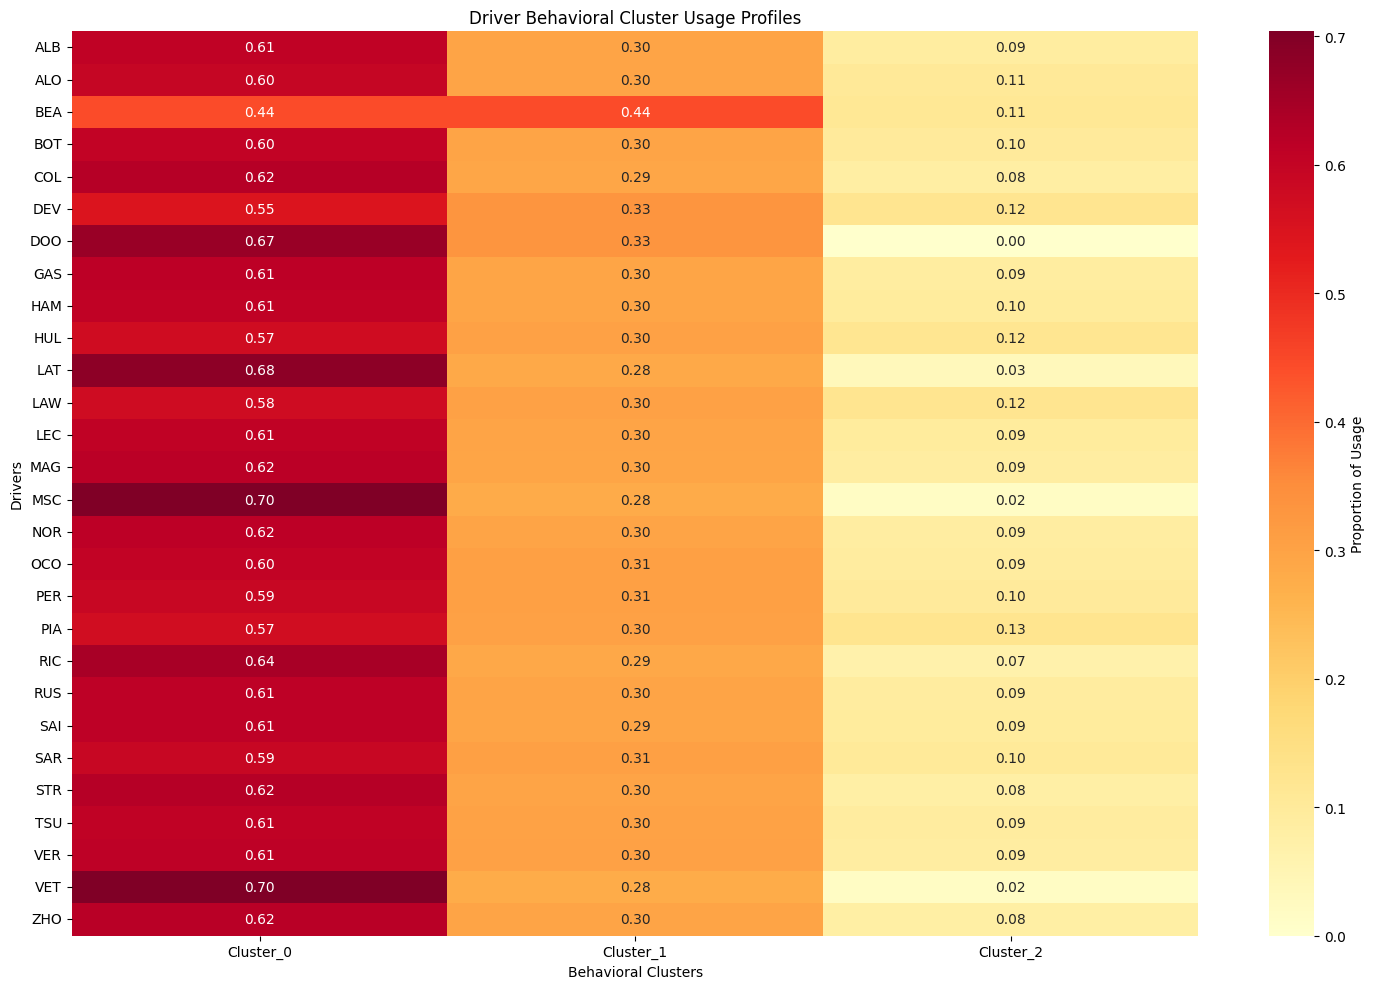

In [16]:
# Stage 2: Create driver profiles based on cluster usage
def create_driver_profiles(data, driver_col='Driver', cluster_col='behavioral_cluster'):
    """Create driver profiles showing cluster usage distribution"""
    
    # Calculate cluster distribution for each driver
    driver_cluster_profile = (
        data.groupby([driver_col])[cluster_col]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    
    # Add cluster prefix for clarity
    driver_cluster_profile.columns = [f'Cluster_{int(col)}' for col in driver_cluster_profile.columns]
    
    return driver_cluster_profile

# Create driver profiles
driver_profiles = create_driver_profiles(corner_data)
print("Driver-Cluster Profiles Shape:", driver_profiles.shape)
print("\nFirst 5 drivers' cluster usage:")
print(driver_profiles.head())

# Visualize driver profiles as heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(driver_profiles, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Proportion of Usage'})
plt.title('Driver Behavioral Cluster Usage Profiles')
plt.xlabel('Behavioral Clusters')
plt.ylabel('Drivers')
plt.tight_layout()
plt.show()

Driver Style Clusters: 2, Silhouette Score: 0.657
Driver Style Clusters: 3, Silhouette Score: 0.699
Driver Style Clusters: 4, Silhouette Score: 0.620
Driver Style Clusters: 5, Silhouette Score: 0.608
Driver Style Clusters: 6, Silhouette Score: 0.468
Driver Style Clusters: 7, Silhouette Score: 0.465
Driver Style Clusters: 8, Silhouette Score: 0.451


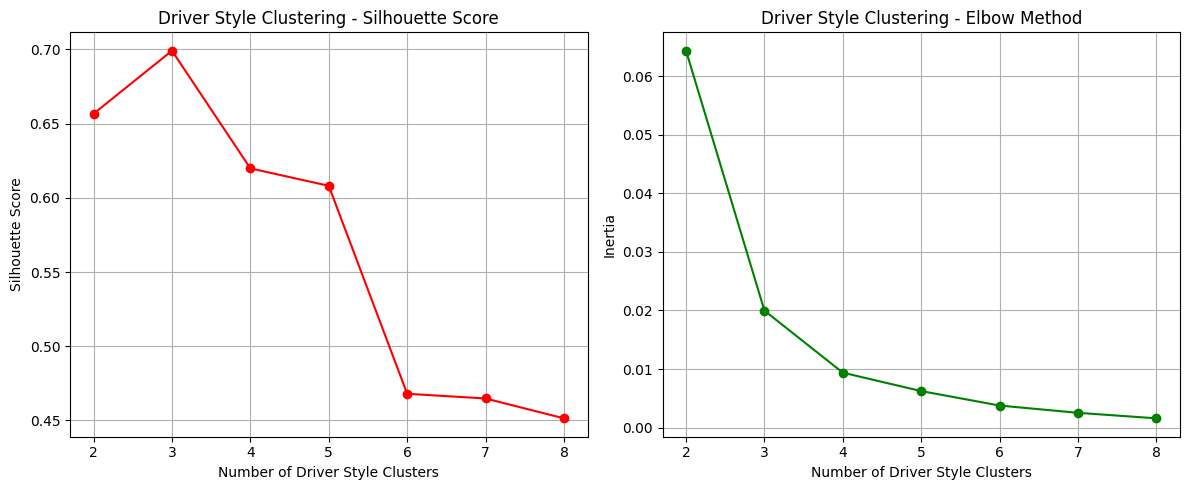

Optimal number of driver style clusters: 3

Driver Style Clustering Results:
Style Group 0: ['DOO', 'LAT', 'MSC', 'VET']
Style Group 1: ['ALB', 'ALO', 'BOT', 'COL', 'DEV', 'GAS', 'HAM', 'HUL', 'LAW', 'LEC', 'MAG', 'NOR', 'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'SAR', 'STR', 'TSU', 'VER', 'ZHO']
Style Group 2: ['BEA']


In [17]:
# Stage 3 (Optional): Cluster drivers based on their behavioral profiles
def cluster_drivers_by_style(driver_profiles, max_clusters=8):
    """Cluster drivers based on their behavioral cluster usage patterns"""
    
    # Find optimal number of driver style clusters
    cluster_range = range(2, max_clusters + 1)
    silhouette_scores = []
    inertias = []
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        driver_style_labels = kmeans.fit_predict(driver_profiles)
        
        silhouette_avg = silhouette_score(driver_profiles, driver_style_labels)
        silhouette_scores.append(silhouette_avg)
        inertias.append(kmeans.inertia_)
        print(f"Driver Style Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, silhouette_scores, 'ro-')
    plt.xlabel('Number of Driver Style Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Driver Style Clustering - Silhouette Score')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, inertias, 'go-')
    plt.xlabel('Number of Driver Style Clusters')
    plt.ylabel('Inertia')
    plt.title('Driver Style Clustering - Elbow Method')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Use optimal number of clusters
    optimal_driver_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of driver style clusters: {optimal_driver_clusters}")
    
    # Final clustering
    final_kmeans = KMeans(n_clusters=optimal_driver_clusters, random_state=42, n_init=10)
    driver_style_labels = final_kmeans.fit_predict(driver_profiles)
    
    # Add style labels to driver profiles
    driver_profiles['driver_style_cluster'] = driver_style_labels
    
    return driver_profiles, driver_style_labels, optimal_driver_clusters

# Perform driver style clustering
driver_profiles_with_styles, driver_style_labels, n_driver_styles = cluster_drivers_by_style(driver_profiles)

print(f"\nDriver Style Clustering Results:")
for style in range(n_driver_styles):
    drivers_in_style = driver_profiles_with_styles[driver_profiles_with_styles['driver_style_cluster'] == style].index.tolist()
    print(f"Style Group {style}: {drivers_in_style}")

Behavioral Cluster Characteristics (Standardized Values):

Cluster 0:
--------------------
Avg_Throttle_Into: -0.68 (LOW)
Avg_Exit_Speed: -0.66 (LOW)
Avg_Throttle_Out: -0.57 (LOW)
Max_Decel_Into: -0.54 (LOW)
Observations: 2337 (61.1%)

Cluster 1:
--------------------
Avg_Exit_Speed: 1.26 (HIGH)
Avg_Throttle_Into: 1.21 (HIGH)
Avg_Entry_Speed: 1.13 (HIGH)
Max_Accel_Out: -1.11 (LOW)
Observations: 1144 (29.9%)

Cluster 2:
--------------------
Max_Accel_Into: 1.75 (HIGH)
Speed_Consistency: 1.63 (HIGH)
Avg_Entry_Speed: -1.04 (LOW)
Avg_Throttle_Out: 0.85 (HIGH)
Observations: 347 (9.1%)


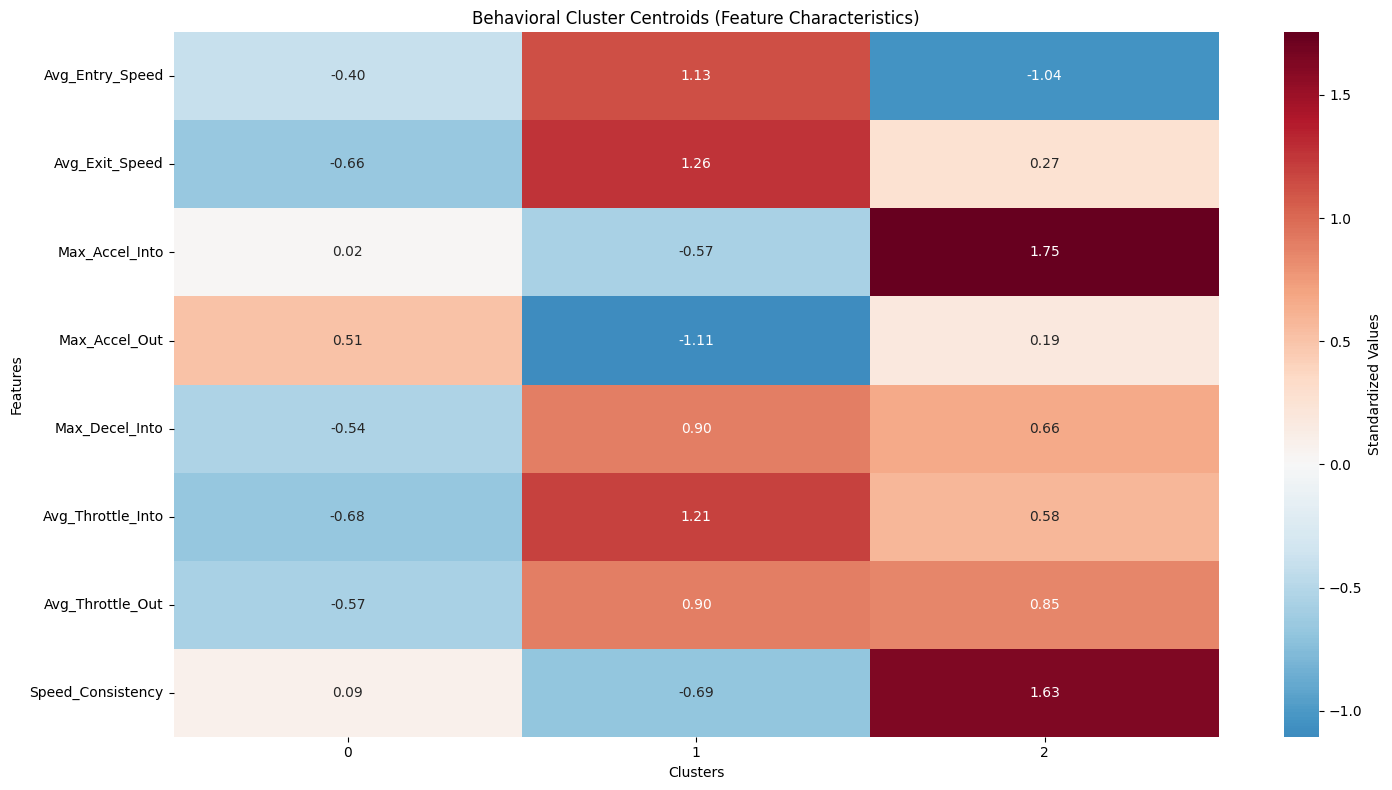

In [18]:
# Analyze behavioral clusters
def analyze_behavioral_clusters(data, scaled_data, cluster_labels, feature_names):
    """Analyze the characteristics of each behavioral cluster"""
    
    # Create analysis dataframe
    cluster_analysis = pd.DataFrame(scaled_data, columns=feature_names)
    cluster_analysis['cluster'] = cluster_labels
    
    # Calculate cluster centroids
    cluster_centroids = cluster_analysis.groupby('cluster')[feature_names].mean()
    
    print("Behavioral Cluster Characteristics (Standardized Values):")
    print("=" * 60)
    
    for cluster_id in sorted(cluster_analysis['cluster'].unique()):
        print(f"\nCluster {cluster_id}:")
        print("-" * 20)
        centroid = cluster_centroids.loc[cluster_id]
        
        # Find most distinctive features (highest absolute values)
        distinctive_features = centroid.abs().sort_values(ascending=False)
        
        for feature in distinctive_features.index[:4]:  # Top 4 features
            value = centroid[feature]
            direction = "HIGH" if value > 0.5 else "LOW" if value < -0.5 else "MEDIUM"
            print(f"{feature}: {value:.2f} ({direction})")
        
        # Count observations in this cluster
        cluster_size = (cluster_labels == cluster_id).sum()
        print(f"Observations: {cluster_size} ({cluster_size/len(cluster_labels)*100:.1f}%)")
    
    return cluster_centroids

# Analyze clusters
cluster_centroids = analyze_behavioral_clusters(
    corner_data, scaled_data, behavioral_labels, features_to_scale
)

# Visualize cluster centroids
plt.figure(figsize=(15, 8))
sns.heatmap(cluster_centroids.T, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, cbar_kws={'label': 'Standardized Values'})
plt.title('Behavioral Cluster Centroids (Feature Characteristics)')
plt.xlabel('Clusters')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [19]:
# Generate comprehensive summary
def generate_clustering_summary(corner_data, driver_profiles_with_styles):
    """Generate a comprehensive summary of the clustering results"""
    
    print("🏎️  F1 DRIVER STYLE ANALYSIS SUMMARY")
    print("=" * 50)
    
    # Basic stats
    n_drivers = corner_data['Driver'].nunique()
    n_observations = len(corner_data)
    n_behavioral_clusters = corner_data['behavioral_cluster'].nunique()
    n_driver_styles = driver_profiles_with_styles['driver_style_cluster'].nunique()
    
    print(f"📊 Dataset Overview:")
    print(f"   • Total Observations: {n_observations}")
    print(f"   • Unique Drivers: {n_drivers}")
    print(f"   • Behavioral Clusters: {n_behavioral_clusters}")
    print(f"   • Driver Style Groups: {n_driver_styles}")
    
    print(f"\n🎯 Behavioral Cluster Usage:")
    cluster_usage = corner_data['behavioral_cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_usage.items():
        percentage = count / len(corner_data) * 100
        print(f"   • Cluster {cluster_id}: {count} observations ({percentage:.1f}%)")
    
    print(f"\n👥 Driver Style Groups:")
    for style in range(n_driver_styles):
        drivers_in_style = driver_profiles_with_styles[
            driver_profiles_with_styles['driver_style_cluster'] == style
        ].index.tolist()
        print(f"   • Style Group {style}: {', '.join(drivers_in_style)}")
    
    # Most distinctive drivers (highest/lowest cluster usage)
    print(f"\n🏆 Most Distinctive Driver Behaviors:")
    for col in driver_profiles.columns:
        if col != 'driver_style_cluster':
            max_user = driver_profiles[col].idxmax()
            max_value = driver_profiles[col].max()
            print(f"   • {col} specialist: {max_user} ({max_value:.2f})")

# Generate final summary
generate_clustering_summary(corner_data, driver_profiles_with_styles)

# Save results
corner_data.to_csv('../corner_data_with_clusters.csv', index=False)
driver_profiles_with_styles.to_csv('../driver_behavioral_profiles.csv')
print("\n💾 Results saved to:")
print("   • corner_data_with_clusters.csv")
print("   • driver_behavioral_profiles.csv")

🏎️  F1 DRIVER STYLE ANALYSIS SUMMARY
📊 Dataset Overview:
   • Total Observations: 3828
   • Unique Drivers: 28
   • Behavioral Clusters: 3
   • Driver Style Groups: 3

🎯 Behavioral Cluster Usage:
   • Cluster 0: 2337 observations (61.1%)
   • Cluster 1: 1144 observations (29.9%)
   • Cluster 2: 347 observations (9.1%)

👥 Driver Style Groups:
   • Style Group 0: DOO, LAT, MSC, VET
   • Style Group 1: ALB, ALO, BOT, COL, DEV, GAS, HAM, HUL, LAW, LEC, MAG, NOR, OCO, PER, PIA, RIC, RUS, SAI, SAR, STR, TSU, VER, ZHO
   • Style Group 2: BEA

🏆 Most Distinctive Driver Behaviors:
   • Cluster_0 specialist: VET (0.70)
   • Cluster_1 specialist: BEA (0.44)
   • Cluster_2 specialist: PIA (0.13)

💾 Results saved to:
   • corner_data_with_clusters.csv
   • driver_behavioral_profiles.csv


In [20]:
corner_data.to_excel('../clustered_corner_data2022-24.xlsx')